# Classification
$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$

In this project, I use **classification** to predict which of a small set of classes an observation belongs to. Mathematically, the aim is to find $y$, a **label** based on knowing a feature vector $\x$. Throughout this notebook I use logistics regression to classify the gender of a person based on weight and height data. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## A Motivating Example Using `sklearn`: Heights and Weights of Males and Females 

In [2]:
dflog = pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


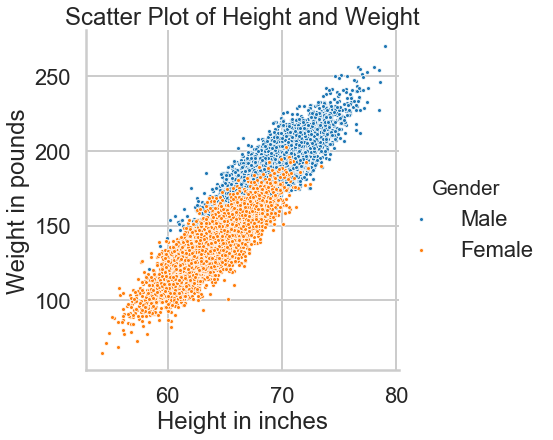

In [3]:
# Creating a scatter plot of Weight vs. Height 
sns.pairplot(x_vars=["Height"], y_vars=["Weight"], data=dflog, hue="Gender", height=6, plot_kws={"s": 15})
plt.xlabel("Height in inches")
plt.ylabel("Weight in pounds")
plt.title("Scatter Plot of Height and Weight")
plt.show()

### Training and Test Datasets

I must ensure two things when fitting models:

* I have found the best model (in terms of model parameters).
* The model is highly likely to generalize i.e. perform well on unseen data.

<br/>
<div class="span5 alert alert-success">
<h4>Purpose of splitting data into Training/Testing sets:</h4>
<ul>
A built model with the requirement to fit the data well will only fit <b>THIS</b> dataset and not new data. Thus to model for predictions, one simple solution is to leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest. </li>
</ul>
</div>

Below, I split the data into a training and test set, then train on the training set, and test for accuracy on the testing set:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height','Weight']].values, 
                                              (dflog.Gender == "Male").values,random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(Xlr, ylr)
# Print the accuracy from the testing data.
print("Accuracy score from testing data:", accuracy_score(clf.predict(Xtestlr), ytestlr))

Accuracy score from testing data: 0.9252


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Tuning the Model

The performance of the model can be imporved through a process called tuning. For tuning the parameters of the model, I use a mix of *cross-validation* and *grid search*. <br>

Below I use the following `cv_score` function to perform K-fold cross-validation and apply a the accuracy score function to each test fold to perform model tuning and selecting the regularization parameter $C$:

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

Below is an example of using the `cv_score` function for a basic logistic regression model without regularization:

In [9]:
clf = LogisticRegression()
score = cv_score(clf, Xlr, ylr)
print(score)

0.9170666666666666


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
# Finding the best model parameters based only on the training set with a 
# possible list of C values and finding the average score using cv_score

#the grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]

score_list = []
for c in Cs:
    logreg = LogisticRegression(solver='lbfgs', C=c)
    score = cv_score(logreg, Xlr, ylr)
    score_list.append(score)
    print("C_value: {}, Score: {}".format(c, score))
    
print(max(score_list))

C_value: 0.001, Score: 0.9122666666666668
C_value: 0.1, Score: 0.9172
C_value: 1, Score: 0.9172
C_value: 10, Score: 0.9172
C_value: 100, Score: 0.9172
0.9172


With the exception of C-value = 0.001, all C values return the same average accuracy score. The minimum C value to achieve the highest score is 0.1. Thus it can be said that the optimal C-value is 0.1.

In [13]:
# Estimating how this model will predict on unseen data in the following way:
# by using the C obtained from the procedure earlier and calculating the accuracy on the test data

# Instantiate the classifier
logreg = LogisticRegression(solver='lbfgs', C=0.1)

# Fit the classifier 
logreg.fit(Xlr, ylr)

# predict the y values
y_pred = logreg.predict(Xtestlr)

# Print the accuracy from y_pred and y_test .
print("Accuracy score:",accuracy_score(y_pred, ytestlr))

Accuracy score: 0.9252


### Black Box Grid Search in `sklearn`

In [14]:
# Using scikit-learn's GridSearchCV tool to perform cross validation and grid search.
from sklearn.model_selection import GridSearchCV

# # 0.001 to 1000 
c_space = np.logspace(-3, 3, 7)
param_grid = {'C': c_space}

# Instantiate the classifier
logreg = LogisticRegression(solver='lbfgs')
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit the training data to the classifier
logreg_cv.fit(Xlr, ylr)

# return the best parameters and the best score
params = logreg_cv.best_params_
score = logreg_cv.best_score_

print("Best Parameters: {}, Best Score: {}".format(params, score))

y_pred = logreg_cv.predict(Xtestlr)

test_score = accuracy_score(y_pred, ytestlr)
print("Accuracy score for test set: {}".format(test_score))

# Hyperparameters for the classfier after GridSearchCV
# logreg_cv.best_estimator_

Best Parameters: {'C': 1.0}, Best Score: 0.9168
Accuracy score for test set: 0.9252


As you can see accuracy scores can be computed for both training/test sets. Thus, the model can be used to predict on any set of data. <br>

The model does not give me the exact same parameters (C=1.0), but actually a lower accuracy score for the training set. However, the test accuracy score is the same at 0.9256

## A Walkthrough of the Math Behind Logistic Regression

Below I set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter). <br> 

The `cv_optimize` is implemented as a dictionary `parameters`, a training set `Xtrain` (as a samples x features array), and a set of labels `ytrain`. <br>

The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each fold. <br>

Finally, it prints the best value of the parameters and returns the best classifier:

In [15]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

Next, I use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. <br>

It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. <br>

The dataframe is split into 80% training and 20% testing by default. I then train the model on the training set using cross-validation. 

Having obtained the best classifier using `cv_optimize`, retrain on the entire training set is retrained and the training and testing accuracy is calculated. The split data and the trained classifier is returned: 

In [16]:
from sklearn.model_selection import train_test_split

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

## Logistic Regression:

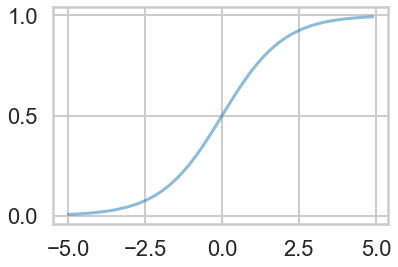

In [17]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [18]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [19]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           dflog, ['Weight', 'Height'], 'Gender','Male')

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data:     0.92


C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklea

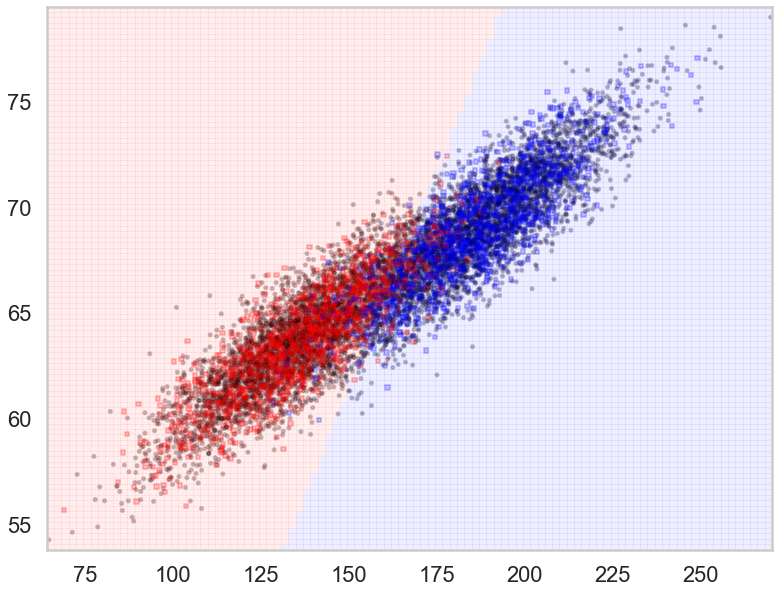

In [22]:
plt.figure(figsize=(13,10))
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);

In the figure here showing the results of the logistic regression, we plot the actual labels of both the training(circles) and test(squares) samples. The 0's (females) are plotted in red, the 1's (males) in blue. We also show the classification boundary, a line (to the resolution of a grid square). Every sample on the red background side of the line will be classified female, and every sample on the blue side, male. Notice that most of the samples are classified well, but there are misclassified people on both sides, as evidenced by leakage of dots or squares of one color ontothe side of the other color. Both test and traing accuracy are about 92%.

### Maximizing the Probability of the Training Set

In statistics, maximum likelihood estimation (MLE) is a method of estimating the parameters of a probability distribution by maximizing a likelihood function, so that under the assumed statistical model the observed data is most probable. **Probabilistic estimation using maximum likelihood is equivalent to Empiricial Risk Minimization using the negative log-likelihood**. For this process, all that needs to be done is to minimize the negative log-likelihood over the training samples.

`sklearn` will return the probabilities for our samples, or for that matter, for any input vector set $\{\v{x}_i\}$, i.e. $P(y_i | \v{x}_i, \v{w})$:

In [23]:
clf_l.predict_proba(Xtest_l)

array([[5.00161882e-03, 9.94998381e-01],
       [9.85465735e-01, 1.45342652e-02],
       [7.34589814e-01, 2.65410186e-01],
       ...,
       [1.74555199e-04, 9.99825445e-01],
       [8.23512229e-03, 9.91764878e-01],
       [9.85736724e-01, 1.42632756e-02]])

### Discriminative vs Generative Classifier

Logistic regression is what is known as a **discriminative classifier** - a soft boundary between/among classes. Another paradigm is the **generative classifier**. For more examples of generative classifiers, look [here](https://en.wikipedia.org/wiki/Generative_model). 

Below, I plotted the probabilities obtained from `predict_proba`, overlayed on the samples with their true labels:

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:67: UserWarning: The following kwargs were not used by contour: 'axes'
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:68: UserWarning: The following kwargs were not used by contour: 'axes'


TypeError: clabel() got an unexpected keyword argument 'axes'

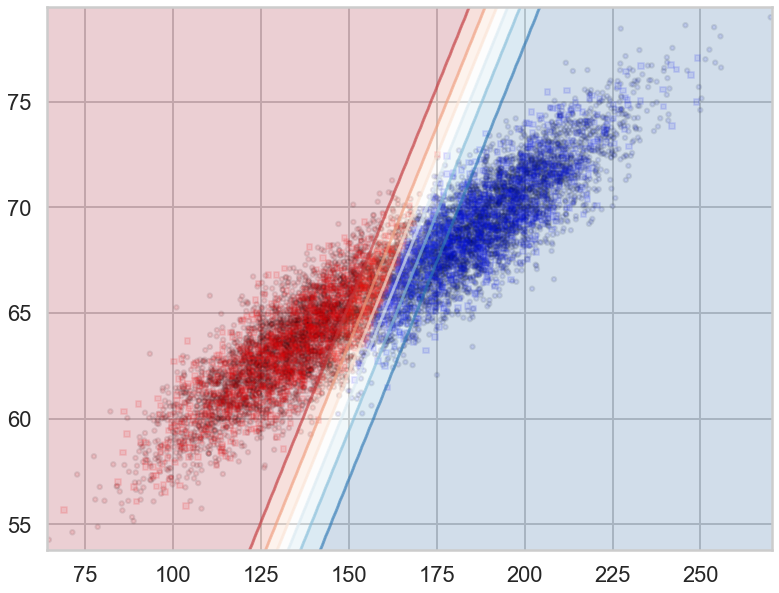

In [26]:
plt.figure(figsize=(13,10))
ax = plt.gca()
points_plot_prob(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, psize=20, alpha=0.1);

Notice that lines of equal probability, as might be expected are stright lines. What the classifier does is very intuitive: if the probability is greater than 0.5, it classifies the sample as type '1' (male), otherwise it classifies the sample to be class '0'. Thus in the diagram above, where we have plotted predicted values rather than actual labels of samples, there is a clear demarcation at the 0.5 probability line.

Again, this notion of trying to obtain the line or boundary of demarcation is what is called a **discriminative** classifier. The algorithm tries to find a decision boundary that separates the males from the females. To classify a new sample as male or female, it checks on which side of the decision boundary the sample falls, and makes a prediction. In other words we are asking, given $\v{x}$, what is the probability of a given $y$, or, what is the likelihood $P(y|\v{x},\v{w})$?

# End of Notebook